In [1]:
from helpers import *
from dataset import *
from model256 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [2]:
DEBAG = False
#DEBAG = True

In [3]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    }, 
)

(5, 184, 630, 630)
(5, 184, 630, 630)


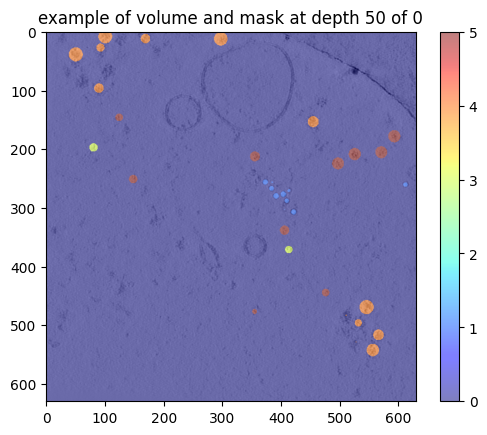

In [4]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
diff =["denoised"]

valid_id = ["TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4",'TS_99_9']
test_id = ["TS_5_4",'TS_99_9']

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        #y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(valid_id[idx], mask_size)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=50)

In [5]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start 
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) >= 0:
                    self.indices.append((idx, start, end))
            start = d - patch_size
            end = d
            if np.sum(mask_data[idx][start:end]) >= 0:
                self.indices.append((idx, start, end))


    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)*9

    def __getitem__(self, i):
        idx,seg = i//9,i%9
        seg_x,seg_y = seg//3,seg%3
        idx, start, end = self.indices[idx]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)
        volume = volume[:, seg_x*187:seg_x*187+256, seg_y*187:seg_y*187+256]
        mask   = mask[:, seg_x*187:seg_x*187+256, seg_y*187:seg_y*187+256]

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
        
    # 4. ランダム90度回転を適用
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
])


In [6]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=64, 
    stride=32,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=64, 
    stride=32,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)

225
torch.Size([1, 1, 64, 256, 256]) torch.Size([1, 1, 64, 256, 256])


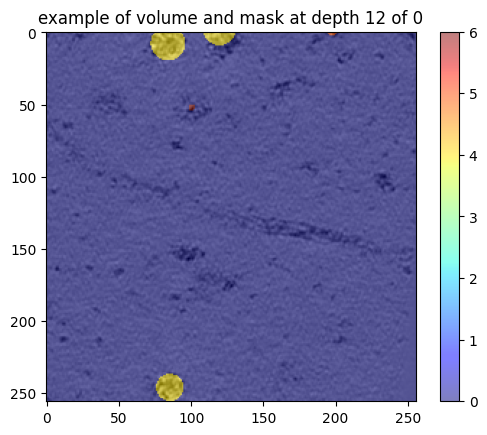

287001
torch.Size([1, 1, 64, 256, 256]) torch.Size([1, 1, 64, 256, 256])


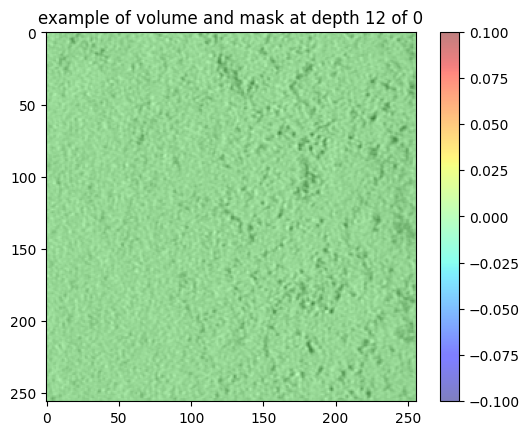

1404


In [7]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [8]:
GPU_ID = 3
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=False,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

cuda:3


In [9]:
global train_batch, test_batch

In [10]:
from torch.optim.lr_scheduler import LambdaLR
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn

# 学習ループにCV計算を追加
num_epochs = 100
learning_rate = 1e-3

optimizer = torch.optim.AdamW(
    net.parameters(),
    lr=learning_rate,
    weight_decay=0.01,
    amsgrad=False,
    betas=(0.9, 0.999),
    eps=1e-08,
    capturable=False,
    differentiable=False,
    foreach=None,
    fused=None
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 1

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in range(num_epochs):
    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 不要な次元を削除
        volumes = volumes.squeeze(1)
        masks = masks.squeeze(1)

        # マスクが全て0の場合はスキップ
        if np.sum(masks) == 0:
            continue

        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        # 勾配を毎回リセット
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss']  # 勾配累積がないためそのまま使用

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        global_step += 1

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")

    # 5エポックごとにCVスコアを計算
    if epoch % 5 == 0:
        gb, lb_score, mask_loss, probability = evaluate_256cv(net, test_id, cfg, valid_dir, device, mask_size)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア: {lb_score:.4f}")
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    mask_losses.append(np.mean(mask_loss))


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/100
----------
train_loss: 1.5635
valid_loss: 1.6295
CVスコア: 0.0000
         particle_type   P   T  hit  precision  recall  f-beta4
0         apo-ferritin  23  82    0        0.0     0.0      0.0
1         beta-amylase  30  31    0        0.0     0.0      0.0
2   beta-galactosidase   7  36    0        0.0     0.0      0.0
3             ribosome   2  96    0        0.0     0.0      0.0
4        thyroglobulin   5  79    0        0.0     0.0      0.0
5  virus-like-particle   2  24    0        0.0     0.0      0.0
エポック 2/100
----------
train_loss: 0.7489
エポック 3/100
----------
train_loss: 0.2432
エポック 4/100
----------
train_loss: 0.1164
エポック 5/100
----------
train_loss: 0.0804
エポック 6/100
----------
train_loss: 0.0632
valid_loss: 0.0713
CVスコア: 0.0932
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    0  82    0   0.000000  0.000000  0.000000
1         beta-amylase    2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase    1  36    0

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0321
CVスコア: 0.6512
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   78  36   34   0.435897  0.944444  0.883792
1         beta-amylase   68  21    1   0.014706  0.047619  0.042079
2   beta-galactosidase  126  24   17   0.134921  0.708333  0.566667
3             ribosome  120  65   38   0.316667  0.584615  0.556897
4        thyroglobulin  205  49   34   0.165854  0.693878  0.584429
5  virus-like-particle   63  13   13   0.206349  1.000000  0.815498
エポック 37/100
----------
train_loss: 0.0137
エポック 38/100
----------
train_loss: 0.0131
エポック 39/100
----------
train_loss: 0.0121
エポック 40/100
----------
train_loss: 0.0126
エポック 41/100
----------
train_loss: 0.0121
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0356
CVスコア: 0.5745
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   74  36   29   0.391892  0.805556  0.758462
1         beta-amylase   54  21    3   0.055556  0.142857  0.130769
2   beta-galactosidase  146  24   14   0.095890  0.583333  0.449057
3             ribosome  103  65   28   0.271845  0.430769  0.416448
4        thyroglobulin  199  49   34   0.170854  0.693878  0.587996
5  virus-like-particle   78  13   13   0.166667  1.000000  0.772727
エポック 42/100
----------
train_loss: 0.0117
エポック 43/100
----------
train_loss: 0.0105
エポック 44/100
----------
train_loss: 0.0103
エポック 45/100
----------
train_loss: 0.0105
エポック 46/100
----------
train_loss: 0.0112
valid_loss: 0.0352
CVスコア: 0.4141
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   83  82   34   0.409639  0.414634  0.414337
1         beta-amylase    1  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  161  36   17   0.105

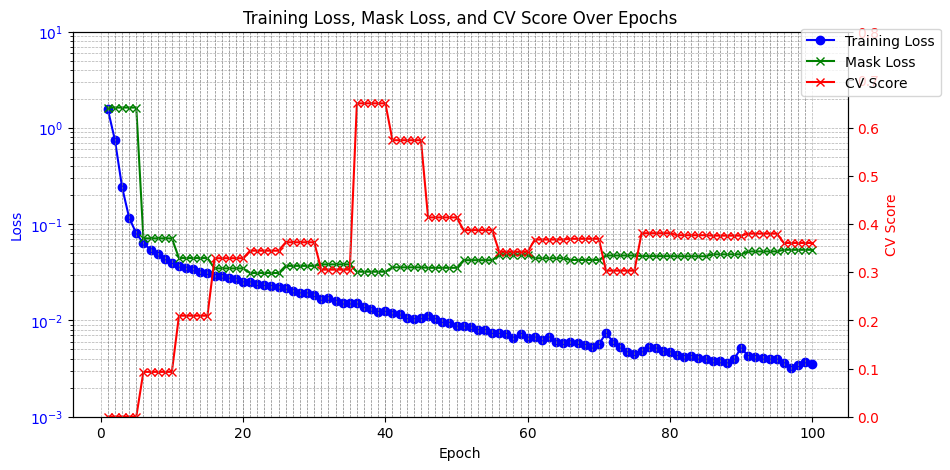

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [12]:
volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

NameError: name 'mask_size2' is not defined

In [ ]:
Class =1
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(probability[Class].max(0)>0.05)
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('pred')

on_hot =np.eye(7)[masks]
im2 = axes[1].imshow(on_hot[0,:,:,:,Class].max(0))
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('truth')